In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import gsw
import cmocean as cm
# import xrftd
import matplotlib.colors as colors

In [2]:
import nc_time_axis

In [3]:
from dask.distributed import Client
import dask
import os

# os.environ["MALLOC_TRIM_THRESHOLD_"] = str(dask.config.get("distributed.nanny.environ.MALLOC_TRIM_THRESHOLD_"))
client =Client(n_workers=8, threads_per_worker=1, memory_limit="4 GiB",local_directory="/home1/scratch/jmartine/tmp")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 8,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40937,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:45052,Total threads: 1
Dashboard: http://127.0.0.1:48136/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:36847,


In [4]:
from utils import Import_Expt_Front, date_fmt

In [5]:
grid = xr.open_dataset('/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/ICE-CHANEL/ice_canal_HR_output/GRID/domain_zgr_800x1200x50xr.nc').squeeze()

In [6]:
folder = '/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/ICE-CHANEL/ice_canal_HR_output/'
EXF = Import_Expt_Front(folder)

In [7]:
exp_filter = ['expt_001','expt_002','expt_003','expt_004','expt_005','expt_007','expt_008','expt_009','expt_010','expt_250m_test']

In [8]:
dataset_velu_1d_all = EXF.import_multipe_expt('grid_U',vars_of_interest=['uoce'],expt_filter=exp_filter,freq='1d',chunks={'time_counter':1}).sel(time_counter="0002")

In [9]:
dataset_velv_1d_all = EXF.import_multipe_expt('grid_V',vars_of_interest=['voce'],expt_filter=exp_filter,freq='1d',chunks={'time_counter':1}).sel(time_counter="0002")

In [10]:
dataset_velw_1d_all = EXF.import_multipe_expt('grid_W',vars_of_interest=['woce'],expt_filter=exp_filter,freq='1d',chunks={'time_counter':1}).sel(time_counter="0002")

In [11]:
import numpy.fft as fft

In [12]:
grid = xr.open_dataset('/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/ICE-CHANEL/ice_canal_HR_output/GRID/domain_zgr_800x1200x50xr.nc').squeeze()

In [13]:
x = grid.x_coord.isel(y=slice(200,1000))*1000
y = grid.y_coord.isel(y=slice(200,1000))*1000

In [14]:
u = dataset_velu_1d_all.uoce_006.isel(depthu=0,time_counter=0).isel(y=slice(200,1000))
v = dataset_velv_1d_all.voce_006.isel(depthv=0,time_counter=0).isel(y=slice(200,1000))

In [15]:
## See https://github.com/adekunleoajayi/powerspec for more info

def _wavenumber_vector(x,y,Ni,Nj):
    ''' Compute a wavenumber vector  '''
    # - obtain dx and dy
    x1dreg,y1dreg = x[0,:],y[:,0]
    dx=int(np.ceil(x1dreg[1]-x1dreg[0]))
    dy=int(np.ceil(y1dreg[1]-y1dreg[0]))
    
    kx = np.fft.fftfreq(Ni,dx) # two sided
    ky = np.fft.fftfreq(Nj,dy)
    Kmax = max(kx.max(), ky.max())
    
    k, l = np.meshgrid(kx,ky)
    wavnum2D = np.sqrt(k**2 + l**2)
    
    # radial wavenumber
    ddk = 1./(dx*Ni)
    ddl = 1./(dy*Nj)
    
    dK = max(ddk,ddl)
    wavnum1D = dK*np.arange(1,int(Kmax/dK))
    return wavnum1D,wavnum2D,kx,ky,dx,dy

def _get_grad_uv_in_fourier_space(u,v,kx,ky,Ni,Nj):
    ''' gradient of u and v in spectral space
        return dudx,dudy,dvdx,dvdy
        '''
    dudx = np.real(np.fft.ifft2(np.fft.fft2(u)*(1j*kx*2*np.pi)[None, :]));
    dudy = np.real(np.fft.ifft2(np.fft.fft2(u)*(1j*ky*2*np.pi)[:, None]));
    dvdx = np.real(np.fft.ifft2(np.fft.fft2(v)*(1j*kx*2*np.pi)[None, :]));
    dvdy = np.real(np.fft.ifft2(np.fft.fft2(v)*(1j*ky*2*np.pi)[:, None]));
    return dudx,dudy,dvdx,dvdy

def _get_transfer1D(wavnum2D,wavnum1D,spec_2D):
    ''' Compute KE Transfer'''
    transfer = np.zeros(len(wavnum1D))
    for i in range(wavnum1D.size):
        kfilt =  ((wavnum1D[i] - wavnum1D[0]) <= wavnum2D) & (wavnum2D <= wavnum1D[i])
#         print(kfilt)
        transfer[i] = (spec_2D[kfilt]).sum()
    return transfer



def spectra_flux(u,v,x,y):
    '''This fuctions implement the computation of kinetic energy spectral flux.
        flux = \int^{ks}_{k} u ....
        
        Input
            _u : Two dimensional zonal velocity dataset.
            _v : Two dimensional meriodinal velocity dataset.
            navlon : Longitude
            navlat : Latitude
            window : None , 'Hanning' or 'Tukey' : (tappered consine window with /apha = 0.5).
            detrend :
                "both" : detrend the 2D data along both axes.
                "zonal" : detrend the data in the zonal direction only
                "RemoveMean" : Remove only the mean of the data
                "RmeanDtrend" : Remove the mean then detrend the data in both direction
                None : use the raw data
        Return
            wavenumber : Horizontal wavenumber
            flux : kinetic energy spectral flux
        '''
    Nj,Ni = u.shape                                             # Get data shape
    wavenumber,wavenumber_2D,kx,ky,dx,dy = _wavenumber_vector(x,y,Ni,Nj)
    dudx,dudy,dvdx,dvdy = _get_grad_uv_in_fourier_space(u,v,kx,ky,Ni,Nj) # Get gradient of u and v
    # - compute terms
    phi1 = u*dudx + v*dudy
    phi2 = u*dvdx + v*dvdy
    # - compute FFT
    tm1 = (fft.fft2(u).conj())*fft.fft2(phi1)
    tm2 = (fft.fft2(v).conj())*fft.fft2(phi2)
    
    transfer_2D = -1*np.real(tm1 + tm2)/np.square(Ni*Nj) # - KE transfer
    transfer_1D = _get_transfer1D(wavenumber_2D,wavenumber,transfer_2D) # Get 1D transfer : assume isotropy
    flux = np.cumsum(transfer_1D[::-1])[::-1] # - Get flux
    return wavenumber,flux


def grad_uv_dz(u,v):
    dudz = u.diff('depthu')/u.depthu.diff('depthu')
    dvdz = v.diff('depthu')/v.depthu.diff('depthu')
    return dudz, dvdz

def spectra_flux_1D(u3D,v3D,w3D,x,y,zloc=0):
    '''This fuctions implement the computation of kinetic energy spectral flux.
        flux = \int^{ks}_{k} u ....
        
        Input
            _u : Two dimensional zonal velocity dataset.
            _v : Two dimensional meriodinal velocity dataset.
            navlon : Longitude
            navlat : Latitude
            window : None , 'Hanning' or 'Tukey' : (tappered consine window with /apha = 0.5).
            detrend :
                "both" : detrend the 2D data along both axes.
                "zonal" : detrend the data in the zonal direction only
                "RemoveMean" : Remove only the mean of the data
                "RmeanDtrend" : Remove the mean then detrend the data in both direction
                None : use the raw data
        Return
            wavenumber : Horizontal wavenumber
            flux : kinetic energy spectral flux
        '''
    u = u3D.isel(depthu=zloc)
    v3D = v3D.rename({"depthv":"depthu"})
    v = v3D.isel(depthu=zloc)
    w3D_interp = w3D.interp(depthw=u3D.depthu)
    w = w3D_interp.isel(depthu=zloc)
    
    Nj,Ni = u.shape                                             # Get data shape
    wavenumber,wavenumber_2D,kx,ky,dx,dy = _wavenumber_vector(x,y,Ni,Nj)
    dudx,dudy,dvdx,dvdy = _get_grad_uv_in_fourier_space(u,v,kx,ky,Ni,Nj) # Get gradient of u and v
    dudz,dvdz = grad_uv_dz(u3D,v3D)
    # - compute terms
    phi1 = u*dudx + v*dudy #+ w*dudz.isel(depthu=zloc)
    phi2 = u*dvdx + v*dvdy #+ w*dvdz.isel(depthu=zloc)
    # - compute FFT
    tm1 = (fft.fft(u,axis=1).conj())*fft.fft(phi1,axis=1)
    tm2 = (fft.fft(v,axis=1).conj())*fft.fft(phi2,axis=1)
    
    transfer_2D = -1*np.real(tm1 + tm2)/np.square(Ni) # - KE transfer
    transfer_1D = transfer_2D[:,:len(wavenumber)]
    flux = np.cumsum(transfer_1D[:, ::-1],axis=1)[:, ::-1] # - Get flux
    return wavenumber,flux

In [16]:
u = dataset_velu_1d_all.uoce_006.isel(time_counter=0).isel(y=slice(200,1000))
v = dataset_velv_1d_all.voce_006.isel(time_counter=0).isel(y=slice(200,1000))
w = dataset_velw_1d_all.woce_006.isel(time_counter=0).isel(y=slice(200,1000))

In [17]:
wavenumber, flux_1d = spectra_flux_1D(u,v,w,x,y,zloc=0)
u = dataset_velu_1d_all.uoce_006.isel(depthu=0,time_counter=0).isel(y=slice(200,1000))
v = dataset_velv_1d_all.voce_006.isel(depthv=0,time_counter=0).isel(y=slice(200,1000))
wavenumber, flux_2d = spectra_flux(u,v,x,y)

/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 9.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 9.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [18]:
m_flux =np.mean(flux_1d,axis=0)

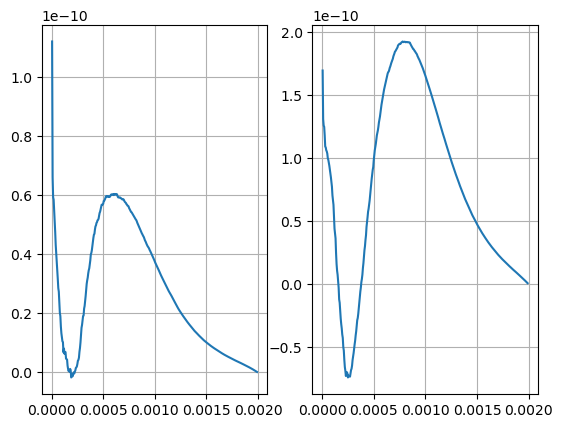

In [19]:
fig,ax=plt.subplots(1,2)
ax[0].plot(wavenumber, m_flux)
ax[1].plot(wavenumber, flux_2d)
ax[0].grid()
ax[1].grid()

In [20]:
wavenumber, flux = spectra_flux(u,v,x,y)


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 9.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


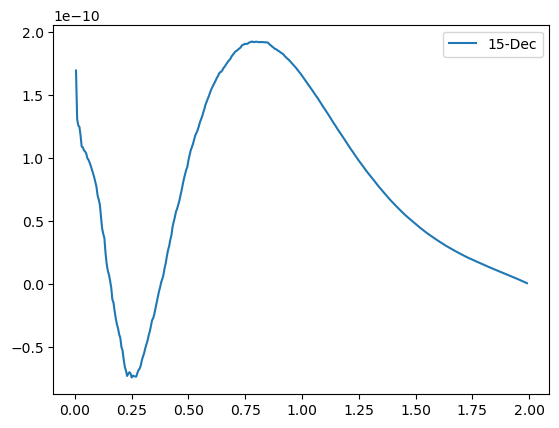

In [21]:
plt.plot(wavenumber*1000,flux,label="15-Dec")

plt.legend()

In [22]:
u = dataset_velu_1d_all.uoce_006.isel(time_counter=0).isel(y=slice(200,1000))
v = dataset_velv_1d_all.voce_006.isel(time_counter=0).isel(y=slice(200,1000))
w = dataset_velw_1d_all.woce_006.isel(time_counter=0).isel(y=slice(200,1000))

wavenumber, flux = spectra_flux_1D(u,v,w,x,y,zloc=0)
m_flux =np.mean(flux_1d,axis=0)
std_flux =np.std(flux_1d,axis=0)

/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 9.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [23]:
flux.shape

(800, 398)

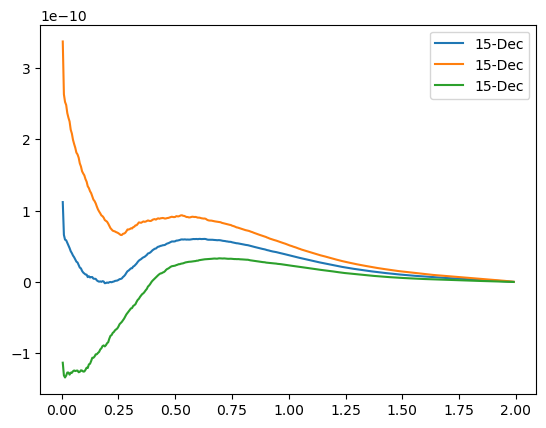

In [24]:
plt.plot(wavenumber*1000,m_flux,label="15-Dec")
plt.plot(wavenumber*1000,m_flux+std_flux,label="15-Dec")
plt.plot(wavenumber*1000,m_flux-std_flux,label="15-Dec")

plt.legend()

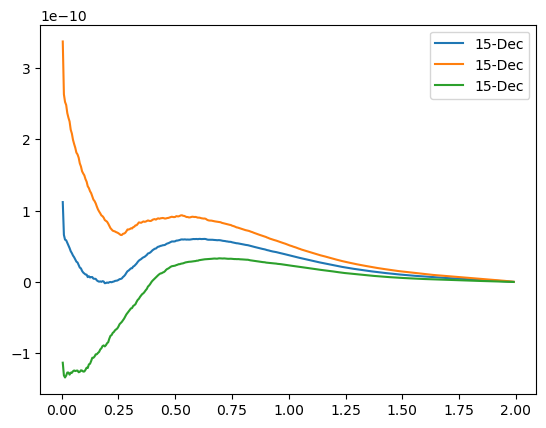

In [25]:
plt.plot(wavenumber*1000,m_flux,label="15-Dec")
plt.plot(wavenumber*1000,m_flux+std_flux,label="15-Dec")
plt.plot(wavenumber*1000,m_flux-std_flux,label="15-Dec")

plt.legend()

In [34]:
wavenumber = np.zeros((len(dataset_velu_1d_all.time_counter),399))
flux = np.zeros((len(dataset_velu_1d_all.time_counter),1000,399))
# flux_std = np.zeros((len(dataset_velu_1d_all.time_counter),800,399))

counter=0
for time in dataset_velu_1d_all.time_counter:
    print(counter)
    u = dataset_velu_1d_all.uoce_006.sel(time_counter=time).isel(y=slice(100,1100))
    v = dataset_velv_1d_all.voce_006.sel(time_counter=time).isel(y=slice(100,1100))
    w = dataset_velw_1d_all.woce_006.sel(time_counter=time).isel(y=slice(100,1100))
    
    wavenumber_, flux_ = spectra_flux_1D(u,v,w,x,y,zloc=27)
    
#     m_flux =np.mean(flux_,axis=0)
#     std_flux =np.std(flux_,axis=0)
    
    wavenumber[counter,:] = wavenumber_
    flux[counter,:,:] = flux_
#     flux_std[counter,:] = std_flux
    
    counter+=1

0


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


1


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


2


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


3


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


4


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


5


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


6


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


7


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


8


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


9


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


10


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


11


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


12


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


13


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


14


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


15


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


16


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


17


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


18


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


19


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


20


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


21


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


22


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


23


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


24


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


25


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


26


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


27


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


28


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


29


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


30


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


31


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


32


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


33


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


34


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


35


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


36


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


37


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


38


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


39


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


40


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


41


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


42


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


43


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


44


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


45


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


46


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


47


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


48


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


49


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


50


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


51


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


52


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


53


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


54


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


55


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


56


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


57


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


58


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


59


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


60


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


61


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


62


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


63


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


64


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


65


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


66


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


67


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


68


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


69


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


70


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


71


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


72


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


73


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


74


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


75


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


76


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


77


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


78


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


79


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


80


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


81


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


82


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


83


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


84


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


85


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


86


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


87


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


88


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


89


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


90


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


91


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


92


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


93


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


94


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


95


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


96


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


97


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


98


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


99


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


100


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


101


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


102


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


103


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


104


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


105


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


106


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


107


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


108


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


109


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


110


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


111


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


112


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


113


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


114


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


115


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


116


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


117


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


118


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


119


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


120


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


121


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


122


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


123


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


124


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


125


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


126


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


127


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


128


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


129


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


130


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


131


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


132


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


133


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


134


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


135


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


136


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


137


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


138


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


139


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


140


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


141


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


142


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


143


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


144


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


145


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


146


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


147


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


148


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


149


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


150


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


151


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


152


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


153


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


154


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


155


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


156


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


157


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


158


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


159


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


160


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


161


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


162


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


163


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


164


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


165


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


166


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


167


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


168


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


169


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


170


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


171


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


172


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


173


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


174


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


175


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


176


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


177


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


178


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


179


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


180


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


181


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


182


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


183


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


184


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


185


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


186


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


187


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


188


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


189


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


190


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


191


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


192


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


193


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


194


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


195


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


196


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


197


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


198


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


199


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


200


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


201


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


202


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


203


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


204


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


205


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


206


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


207


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


208


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


209


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


210


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


211


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


212


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


213


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


214


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


215


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


216


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


217


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


218


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


219


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


220


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


221


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


222


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


223


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


224


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


225


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


226


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


227


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


228


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


229


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


230


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


231


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


232


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


233


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


234


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


235


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


236


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


237


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


238


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


239


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


240


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


241


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


242


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


243


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


244


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


245


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


246


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


247


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


248


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


249


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


250


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


251


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


252


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


253


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


254


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


255


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


256


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


257


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


258


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


259


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


260


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


261


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


262


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


263


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


264


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


265


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


266


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


267


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


268


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


269


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


270


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


271


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


272


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


273


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


274


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


275


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


276


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


277


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


278


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


279


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


280


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


281


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


282


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


283


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


284


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


285


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


286


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


287


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


288


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


289


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


290


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


291


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


292


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


293


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


294


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


295


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


296


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


297


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


298


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


299


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


300


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


301


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


302


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


303


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


304


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


305


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


306


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


307


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


308


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


309


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


310


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


311


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


312


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


313


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


314


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


315


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


316


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


317


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


318


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


319


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


320


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


321


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


322


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


323


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


324


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


325


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


326


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


327


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


328


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


329


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


330


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


331


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


332


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


333


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


334


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


335


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


336


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


337


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


338


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


339


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


340


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


341


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


342


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


343


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


344


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


345


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


346


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


347


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


348


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


349


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


350


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


351


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


352


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


353


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


354


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


355


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


356


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


357


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


358


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


359


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


360


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


361


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


362


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


363


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


364


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [35]:
# wavenumber = np.zeros((len(dataset_velu_1d_all.time_counter),399))
# flux = np.zeros((len(dataset_velu_1d_all.time_counter),399))
# flux_std = np.zeros((len(dataset_velu_1d_all.time_counter),399))

# counter=0
# for time in dataset_velu_1d_all.time_counter:
#     print(counter)
#     u = dataset_velu_1d_all.uoce_006.sel(depthu=150,method="nearest").sel(time_counter=time).isel(y=slice(100,1100))
#     v = dataset_velv_1d_all.voce_006.sel(depthv=150,method="nearest").sel(time_counter=time).isel(y=slice(100,1100))
    
#     wavenumber[counter,:], flux[counter,:], flux_std[counter,:] = spectra_flux(u,v,x,y)
    
#     counter+=1

In [36]:
ds = xr.Dataset(
    data_vars=dict(
        KEflux=(["time_counter", "y", "wavenumber"], flux),
#         KEflux_std=(["time_counter", "wavenumber"], flux_std)
    ),
    coords=dict(
        y = ("y",u.y.data),
        wavenumber=("wavenumber", wavenumber[0] ),
        time_counter=dataset_velu_1d_all.time_counter
    ),
    attrs=dict(description="KE energy flux."),
)

In [37]:
ds.to_netcdf("./storage/KE_energy_flux_at_150m_between_125km_from_center_fix_dx_1D.nc")

# Compare between 1 d snapshots

In [103]:
u = dataset_velu_1d_all.uoce_006.isel(time_counter=0).isel(y=slice(100,1100))
v = dataset_velv_1d_all.voce_006.isel(time_counter=0).isel(y=slice(100,1100))
w = dataset_velw_1d_all.woce_006.isel(time_counter=0).isel(y=slice(100,1100))

wavenumber, flux_ = spectra_flux_1D(u,v,w,x,y,zloc=2)

flux_[flux_ == 0]= np.nan

m_flux =np.nanmean(flux_,axis=0)
std_flux =np.nanstd(flux_,axis=0)

/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Text(0.5, 0, 'Wavenumber [1/km]')

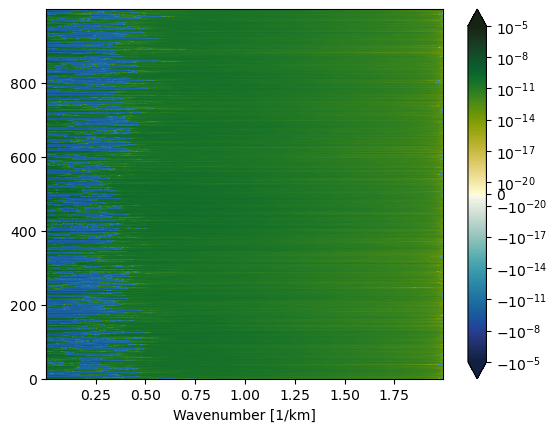

In [104]:
import matplotlib
plt.pcolormesh(wavenumber*1000,range(flux_.shape[0]),flux_,norm=colors.SymLogNorm(linthresh=1e-20,
                                              vmin=-1e-5, vmax=1e-5, base=10),cmap=cm.cm.delta)
plt.colorbar(extend="both")
plt.xlabel("Wavenumber [1/km]")

In [91]:
u = dataset_velu_1d_all.uoce_006.isel(time_counter=0).isel(y=slice(100,1100))
v = dataset_velv_1d_all.voce_006.isel(time_counter=0).isel(y=slice(100,1100))
w = dataset_velw_1d_all.woce_006.isel(time_counter=0).isel(y=slice(100,1100))

wavenumber, flux_ = spectra_flux_1D(u,v,w,x,y,zloc=27)

flux_[flux_ == 0]= np.nan

m_flux =np.nanmean(flux_,axis=0)
std_flux =np.nanstd(flux_,axis=0)

/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


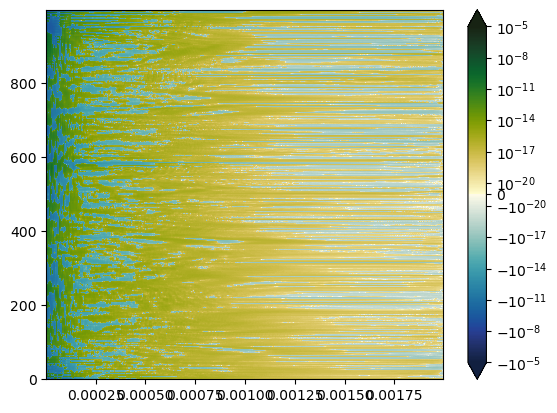

In [92]:
import matplotlib
plt.pcolormesh(wavenumber,range(flux_.shape[0]),flux_,norm=colors.SymLogNorm(linthresh=1e-20,
                                              vmin=-1e-5, vmax=1e-5, base=10),cmap=cm.cm.delta)
plt.colorbar(extend="both")

# Check stored data

In [25]:
ds = xr.open_dataset("./storage/KE_energy_flux_at_5m_between_125km_from_center_fix_dx.nc")
ds_150 = xr.open_dataset("./storage/KE_energy_flux_at_150m_between_125km_from_center_fix_dx.nc")

In [26]:
KEFlux_season = ds.KEflux.groupby("time_counter.season").mean()
KEFlux_season_150 = ds_150.KEflux.groupby("time_counter.season").mean()

In [27]:
KEFlux_season['wavenumber'] = KEFlux_season.wavenumber*1000
KEFlux_season_150['wavenumber'] = KEFlux_season_150.wavenumber*1000

In [28]:
Ls = 8
Rd = 1/Ls
Rd_2 = 1/(2*np.pi*Ls)

/dev/shm/pbs.2882175.datarmor0/ipykernel_26870/3477734289.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(new_label)


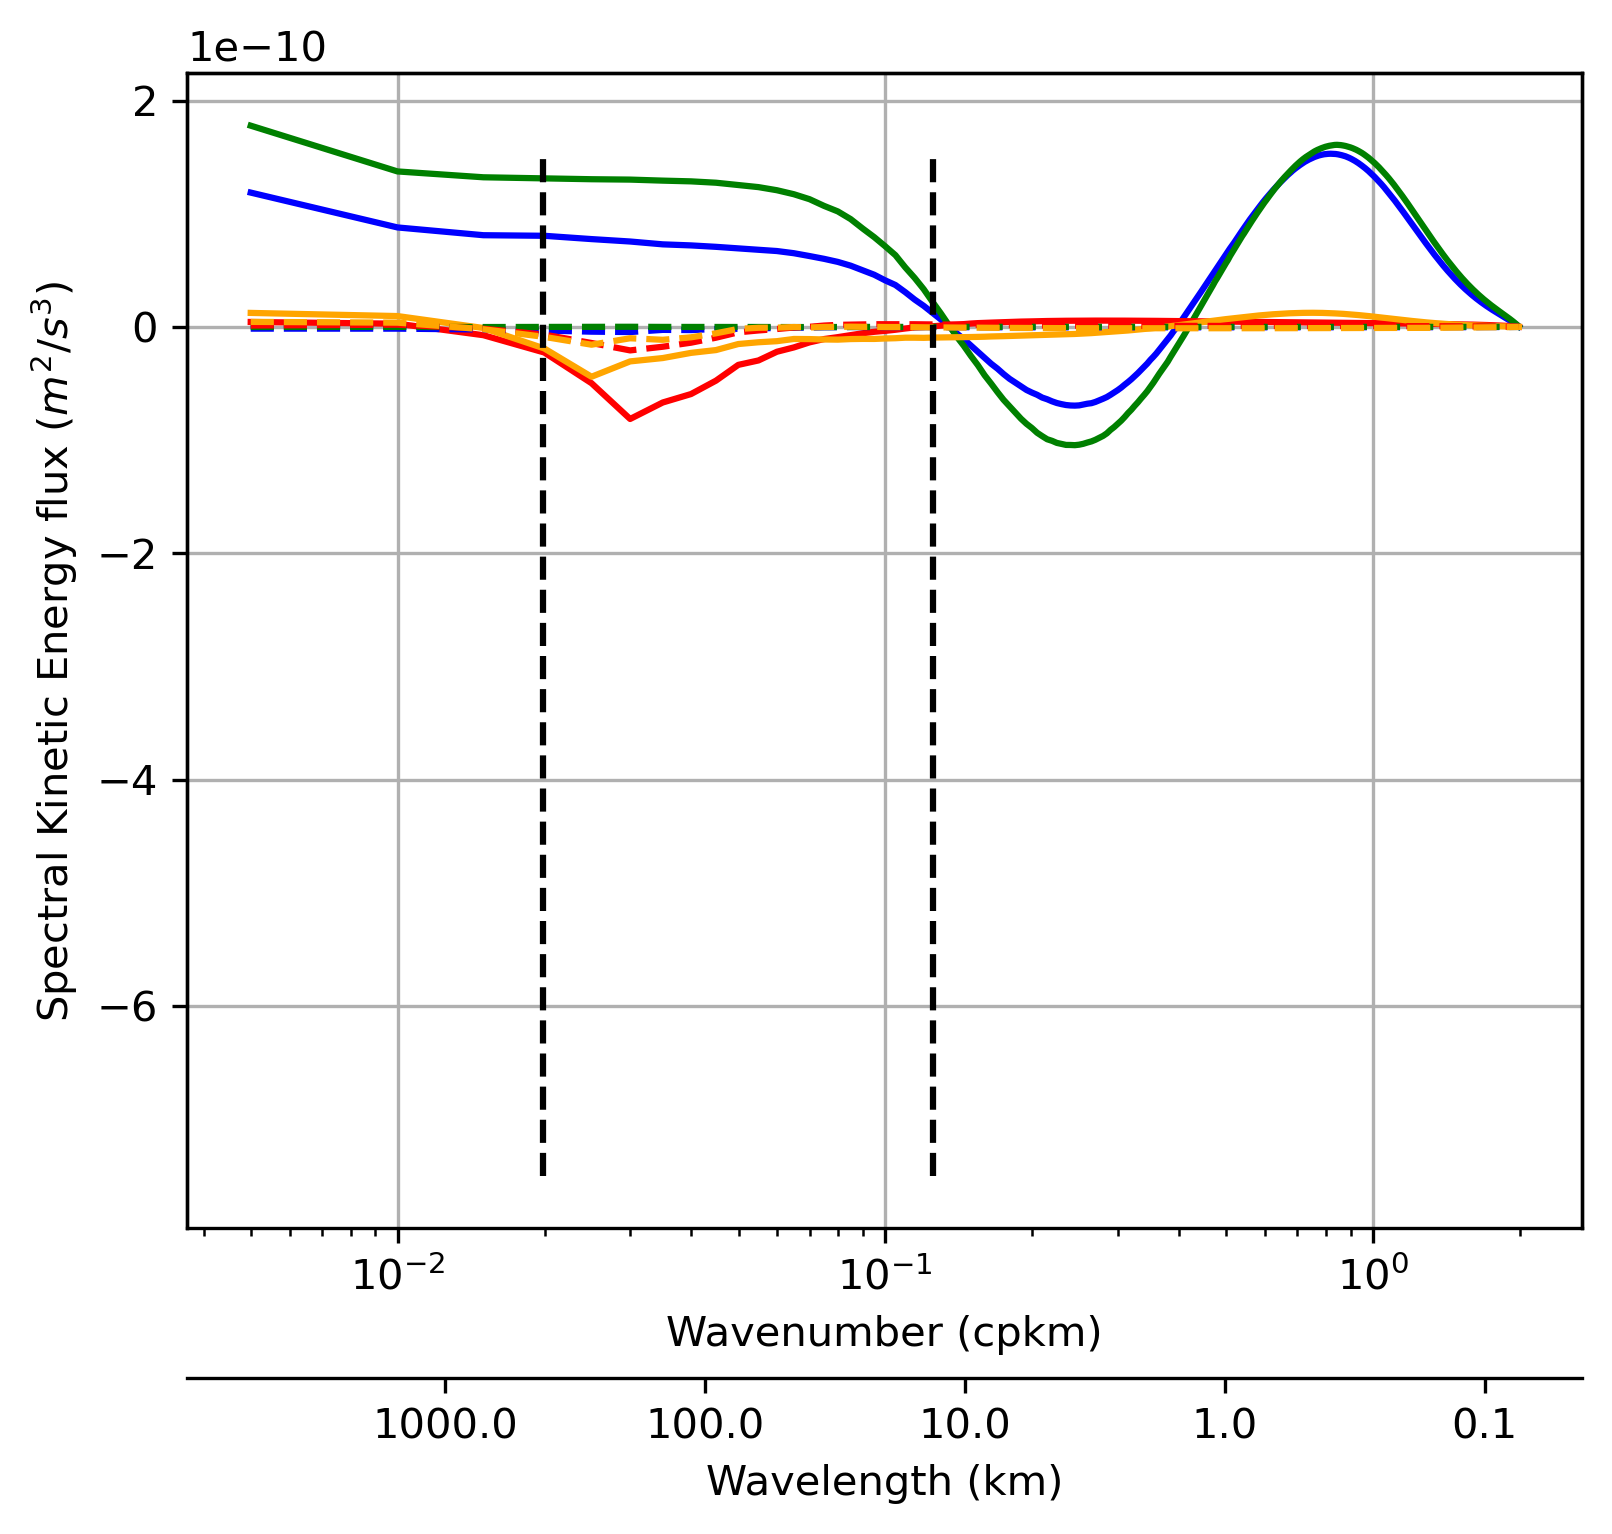

In [29]:
fig, ax = plt.subplots(1,1,figsize=(6,5),dpi=300)

(KEFlux_season).sel(season="DJF").plot(ax=ax,label="DJF",color="blue")
(KEFlux_season).sel(season="MAM").plot(ax=ax,label="MAM",color="green")
(KEFlux_season).sel(season="JJA").plot(ax=ax,label="JJA",color="red")
(KEFlux_season).sel(season="SON").plot(ax=ax,label="SON",color="orange")

(KEFlux_season_150).sel(season="DJF").plot(ax=ax,color="blue",linestyle="--")
(KEFlux_season_150).sel(season="MAM").plot(ax=ax,color="green",linestyle="--")
(KEFlux_season_150).sel(season="JJA").plot(ax=ax,color="red",linestyle="--")
(KEFlux_season_150).sel(season="SON").plot(ax=ax,color="orange",linestyle="--")

ax.plot(0,0,linestyle='--',color='k',label='100m depth')

ax.set_ylabel("Spectral Kinetic Energy flux ($m^2/s^3$)")
ax.set_xlabel("Wavenumber (cpkm)")
ax.grid()

ax.plot([Rd,Rd],[-7.5e-10,1.5e-10],linestyle='--',color='k')
ax.plot([Rd_2,Rd_2],[-7.5e-10,1.5e-10],linestyle='--',color='k')

# ax.set_xlim(0,2)
ax.set_xscale('log')
# ax.set_ylim(-7.5e-8,2e-8)

ax2 = ax.twiny()

ax2.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
ax2.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
ax2.spines['bottom'].set_position(('outward', 36))
ax2.set_xlim(ax.get_xlim())
ax2.set_xlabel("Wavelength (km)")

labels = ax.get_xticklabels()

labels = ax.get_xticklabels()
new_label=list(np.zeros(len(labels)))
count=0
for label in labels:
    nl = np.round(1 / label.get_position()[0], 1)
    if nl==np.inf:
        new_label[count] = "Inf"
    else:
        new_label[count] = "{0}".format(nl)
    count+=1
    
ax2.set_xticklabels(new_label)

ax.set_title("")

plt.savefig('./figures/Energy_flux.pdf', dpi=300, bbox_inches='tight')

In [325]:
new_label

array([-10.        ,          inf,  10.        ,   5.        ,
         3.33333333,   2.5       ,   2.        ,   1.66666667])